# Validating Simulation Grids via Maxwell's Equations

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from mu2e.dataframeprod import DataFrameMaker
#from mu2e.src.fiteval_c import FitFunctionMaker
import cPickle as pkl
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)
#ffm= FitFunctionMaker("../mu2e/src/param_825.csv")
#def ffm_wrapper(x):
#    out = ffm.mag_field_function(x.X,x.Y,x.Z,True)
#    return pd.Series({'Bx':out[0], 'By':out[1], 'Bz':out[2]})
from mu2e import mu2e_ext_path

In [7]:
df_GA05= DataFrameMaker(mu2e_ext_path+'datafiles/FieldMapsGA05/DSMap',use_pickle = True).data_frame
df_Mau10 = DataFrameMaker(mu2e_ext_path+'datafiles/Mau10/Standard_Maps/Mu2e_DSMap',use_pickle = True).data_frame
df_Bus = DataFrameMaker(mu2e_ext_path+'datafiles/FieldMapsPure/DS_buswork_only_fullmap',use_pickle = True).data_frame
#df_Bessel = pkl.load(open('df_Bessel.p','rb'))

In [8]:
df_Mau10_selection = df_Mau10.query('6000<Z<12000 and -600<X<600 and -600<Y<600')[['X','Y','Z','Bx','By','Bz']]
df_GA05_selection = df_GA05.query('6000<Z<12000 and -600<X<600 and -600<Y<600')[['X','Y','Z','Bx','By','Bz']]
#df_Bessel_selection = df_Bessel.query('6000<Z<12000 and -600<X<600 and -600<Y<600')[['X','Y','Z','Bx','By','Bz']]
df_Bus_selection = df_Bus.query('6000<Z<12000 and -600<X<600 and -600<Y<600')[['X','Y','Z','Bx','By','Bz']]

We have generated a dataframe out of the fitting function as well, in order to determine the qualities of an object with known perfect adherence to Maxwell's equations.

In [16]:
df_combo = pd.merge(df_Mau10_selection,df_GA05_selection,on=['X','Y','Z'],suffixes=('m','g'))
#df_Bessel_selection.rename(columns={'Bx':'Bxb','By':'Byb','Bz':'Bzb'},inplace=True)
df_Bus_selection.rename(columns={'Bx':'Bxb','By':'Byb','Bz':'Bzb'},inplace=True)
#df_combo = pd.merge(df_combo,df_Bessel_selection,on=['X','Y','Z'])
df_combo = pd.merge(df_combo,df_Bus_selection,on=['X','Y','Z'])
df_combo.sort_values(['X','Y','Z'],inplace=True)


In [15]:
pd.merge?

In [17]:
df_combo.head()

,X,Y,Z,Bxm,Bym,Bzm,Bxg,Byg,Bzg,Bxb,Byb,Bzb
0,-575.0,-575.0,6021.0,-0.129526,-0.130187,1.453117,-0.130382,-0.131042,1.460711,-0.000383,-0.000530,0.004837
1,-575.0,-575.0,6046.0,-0.130943,-0.131631,1.426714,-0.132953,-0.133664,1.434105,-0.000458,-0.000585,0.004849
2,-575.0,-575.0,6071.0,-0.129244,-0.129916,1.400023,-0.132376,-0.133093,1.406756,-0.000536,-0.000643,0.004837
3,-575.0,-575.0,6096.0,-0.124433,-0.125043,1.374212,-0.128573,-0.129250,1.379852,-0.000611,-0.000699,0.004800
4,-575.0,-575.0,6121.0,-0.116712,-0.117221,1.350412,-0.121676,-0.122268,1.354585,-0.000679,-0.000749,0.004741


For our first pass, we are going to calculate the divergence of the magnetic field.  We are going to do so by using using the Divergence Theorem,
$$\iiint_V(\nabla \cdot F)\ dV = \bigcirc \!\!\!\!\!\!\!\!\iint_S (F\cdot \mathbf{n})\ dS,$$
where we calculate the surface integral around some volume of the normal components of the magnetic field.  In our case, it makes logical sense to calculate the surface integral over a cubic surface.  Using the simulation grid, in which Bx,By,Bz triplets are given in 25mm spacings, we will create 3x3x3 cubes.  The central node on each face will represent the field vector for that face, and thus the total flux is the sum of all 6 faces (properly accounting for the direction of the normal).

We can accomplish this by creating 3D numpy arrays, and using vectorization in an intelligent manner.  We will label each cube by its central node.  We can then compare the total flux for each cube in the two simulations (Mau10 and GA05) that we are considering.  In principle, the flux should be 0 for all cubes; there are no magnetic monopoles (as far as we know).  In practice, the total flux will be non-zero, due to numeric errors.

In [18]:
xs = df_combo.X.unique()
ys = df_combo.Y.unique()
zs = df_combo.Z.unique()

bxs_Mau10 = df_combo.Bxm.reshape(len(xs),len(ys),len(zs))
bys_Mau10 = df_combo.Bym.reshape(len(xs),len(ys),len(zs))
bzs_Mau10 = df_combo.Bzm.reshape(len(xs),len(ys),len(zs))

bxs_GA05 = df_combo.Bxg.reshape(len(xs),len(ys),len(zs))
bys_GA05 = df_combo.Byg.reshape(len(xs),len(ys),len(zs))
bzs_GA05 = df_combo.Bzg.reshape(len(xs),len(ys),len(zs))

#bxs_Bessel = df_combo.Bxb.reshape(len(xs),len(ys),len(zs))
#bys_Bessel = df_combo.Byb.reshape(len(xs),len(ys),len(zs))
#bzs_Bessel = df_combo.Bzb.reshape(len(xs),len(ys),len(zs))

bxs_Bus = df_combo.Bxb.reshape(len(xs),len(ys),len(zs))
bys_Bus = df_combo.Byb.reshape(len(xs),len(ys),len(zs))
bzs_Bus = df_combo.Bzb.reshape(len(xs),len(ys),len(zs))


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: reshape is dep

In [19]:
div_Mau10 = bxs_Mau10[:-2,1:-1,1:-1] - bxs_Mau10[2:,1:-1,1:-1]\
+ bys_Mau10[1:-1,:-2,1:-1] - bys_Mau10[1:-1,2:,1:-1]\
+ bzs_Mau10[1:-1,1:-1,:-2] - bzs_Mau10[1:-1,1:-1,2:]

div_GA05 = bxs_GA05[:-2,1:-1,1:-1] - bxs_GA05[2:,1:-1,1:-1]\
+ bys_GA05[1:-1,:-2,1:-1] - bys_GA05[1:-1,2:,1:-1]\
+ bzs_GA05[1:-1,1:-1,:-2] - bzs_GA05[1:-1,1:-1,2:]

#div_Bessel = bxs_Bessel[:-2,1:-1,1:-1] - bxs_Bessel[2:,1:-1,1:-1]\
#+ bys_Bessel[1:-1,:-2,1:-1] - bys_Bessel[1:-1,2:,1:-1]\
#+ bzs_Bessel[1:-1,1:-1,:-2] - bzs_Bessel[1:-1,1:-1,2:]

div_Bus = bxs_Bus[:-2,1:-1,1:-1] - bxs_Bus[2:,1:-1,1:-1]\
+ bys_Bus[1:-1,:-2,1:-1] - bys_Bus[1:-1,2:,1:-1]\
+ bzs_Bus[1:-1,1:-1,:-2] - bzs_Bus[1:-1,1:-1,2:]

In [21]:
curlxy_Mau10 = bxs_Mau10[1:-1,:-2,1:-1] - bxs_Mau10[1:-1,2:,1:-1]\
+ bys_Mau10[:-2,1:-1,1:-1] - bys_Mau10[2:,1:-1,1:-1]

curlxz_Mau10 = bxs_Mau10[1:-1,1:-1,:-2] - bxs_Mau10[1:-1,1:-1,2:]\
+ bzs_Mau10[:-2,1:-1,1:-1] - bzs_Mau10[2:,1:-1,1:-1]

curlyz_Mau10 = bys_Mau10[1:-1,1:-1,:-2] - bys_Mau10[1:-1,1:-1,2:]\
+ bzs_Mau10[1:-1,:-2,1:-1] - bzs_Mau10[1:-1,2:,1:-1]


curlxy_GA05 = bxs_GA05[1:-1,:-2,1:-1] - bxs_GA05[1:-1,2:,1:-1]\
+ bys_GA05[:-2,1:-1,1:-1] - bys_GA05[2:,1:-1,1:-1]

curlxz_GA05 = bxs_GA05[1:-1,1:-1,:-2] - bxs_GA05[1:-1,1:-1,2:]\
+ bzs_GA05[:-2,1:-1,1:-1] - bzs_GA05[2:,1:-1,1:-1]

curlyz_GA05 = bys_GA05[1:-1,1:-1,:-2] - bys_GA05[1:-1,1:-1,2:]\
+ bzs_GA05[1:-1,:-2,1:-1] - bzs_GA05[1:-1,2:,1:-1]


curlxy_Bus = bxs_Bus[1:-1,:-2,1:-1] - bxs_Bus[1:-1,2:,1:-1]\
+ bys_Bus[:-2,1:-1,1:-1] - bys_Bus[2:,1:-1,1:-1]

curlxz_Bus = bxs_Bus[1:-1,1:-1,:-2] - bxs_Bus[1:-1,1:-1,2:]\
+ bzs_Bus[:-2,1:-1,1:-1] - bzs_Bus[2:,1:-1,1:-1]

curlyz_Bus = bys_Bus[1:-1,1:-1,:-2] - bys_Bus[1:-1,1:-1,2:]\
+ bzs_Bus[1:-1,:-2,1:-1] - bzs_Bus[1:-1,2:,1:-1]

In [22]:
cube_centers = []
for x in xs[1:-1]:
    for y in ys[1:-1]:
        for z in zs[1:-1]:
            cube_centers.append('x{0}_y{1}_z{2}'.format(x,y,z))

In [23]:
df_maxwell = pd.DataFrame({'div_Mau10':div_Mau10.flatten(),'div_GA05':div_GA05.flatten(),
                           'div_Bus':div_Bus.flatten(),
                          'curlxy_Mau10':curlxy_Mau10.flatten(),'curlxy_GA05':curlxy_GA05.flatten(), 'curlxy_Bus':curlxy_Bus.flatten(),
                          'curlxz_Mau10':curlxz_Mau10.flatten(),'curlxz_GA05':curlxz_GA05.flatten(), 'curlxz_Bus':curlxz_Bus.flatten(),
                          'curlyz_Mau10':curlyz_Mau10.flatten(),'curlyz_GA05':curlyz_GA05.flatten(), 'curlyz_Bus':curlyz_Bus.flatten()},
                          index=cube_centers)
df_maxwell.head()

,curlxy_Bus,curlxy_GA05,curlxy_Mau10,curlxz_Bus,curlxz_GA05,curlxz_Mau10,curlyz_Bus,curlyz_GA05,curlyz_Mau10,div_Bus,div_GA05,div_Mau10
x-550.0_y-550.0_z6046.0,0.000007,-0.022671,-0.022246,0.000492,0.001861,-0.001378,-0.000161,0.001936,-0.001370,8.880000e-07,-0.000464,-0.000461
x-550.0_y-550.0_z6071.0,-0.000024,-0.022879,-0.021960,0.000493,-0.007468,-0.010479,-0.000159,-0.007532,-0.010605,-7.820000e-07,-0.000479,-0.000463
x-550.0_y-550.0_z6096.0,-0.000054,-0.021795,-0.020423,0.000477,-0.016689,-0.019264,-0.000164,-0.016892,-0.019521,-1.372000e-06,-0.000461,-0.000434
x-550.0_y-550.0_z6121.0,-0.000080,-0.019465,-0.017715,0.000444,-0.025250,-0.027208,-0.000178,-0.025583,-0.027583,-1.580000e-06,-0.000412,-0.000376
x-550.0_y-550.0_z6146.0,-0.000100,-0.016026,-0.013995,0.000400,-0.032646,-0.033851,-0.000198,-0.033091,-0.034324,-2.412000e-06,-0.000338,-0.000298


In [50]:
#df_maxwell[df_maxwell.div_Bessel==df_maxwell.div_Bessel.min()]

,div_Bessel,div_GA05,div_Mau10
x-25.0_y25.0_z8821.0,-0.000377,6.890000e-07,6.660000e-07


In [48]:
sort(np.abs(df_maxwell.div_GA05.unique()))

array([  0.00000000e+00,   1.11022302e-16,   1.11022302e-16, ...,
         5.44386000e-04,   5.56021000e-04,   5.56163000e-04])

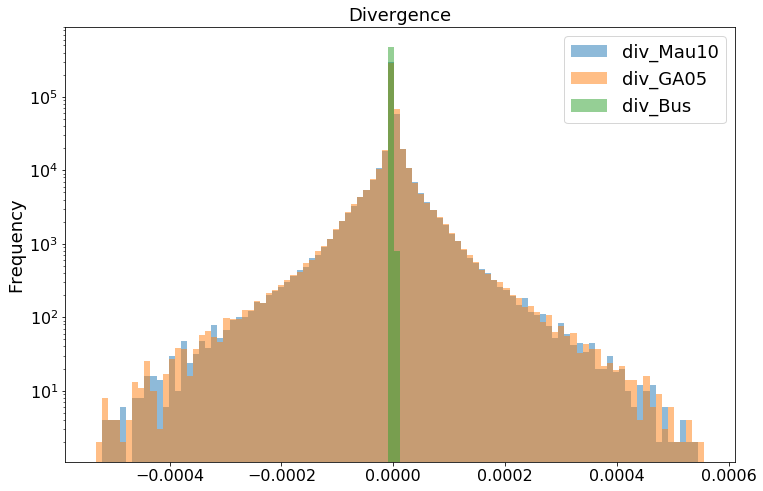

In [37]:
df_maxwell[['div_Mau10','div_GA05','div_Bus']].plot.hist(alpha=0.5, bins=100, logy=True, title='Divergence')

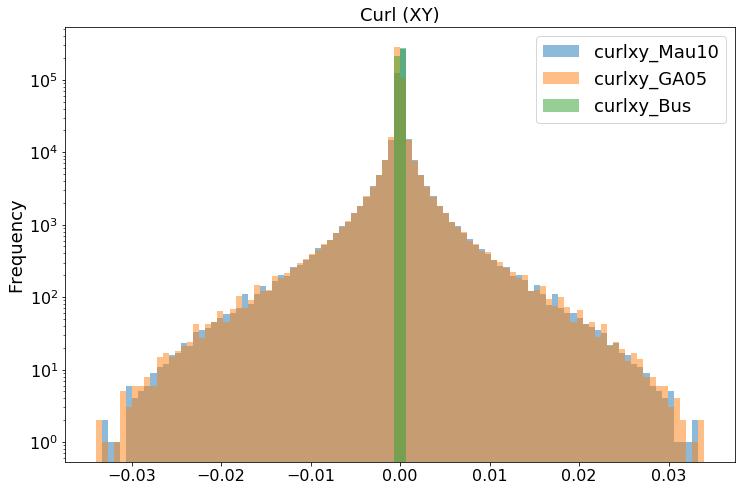

In [34]:
df_maxwell[['curlxy_Mau10','curlxy_GA05', 'curlxy_Bus']].plot.hist(alpha=0.5, bins=100, logy=True, title='Curl (XY)')

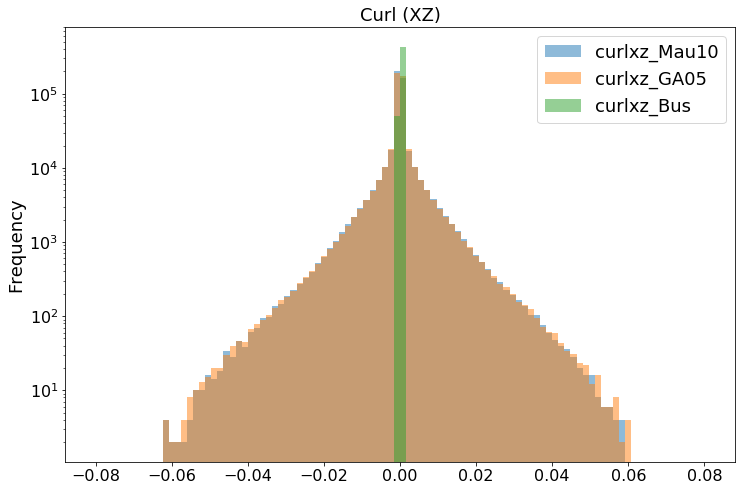

In [28]:
df_maxwell[['curlxz_Mau10','curlxz_GA05','curlxz_Bus']].plot.hist(alpha=0.5, bins=100, logy=True, title='Curl (XZ)', range=(-0.08, 0.08))

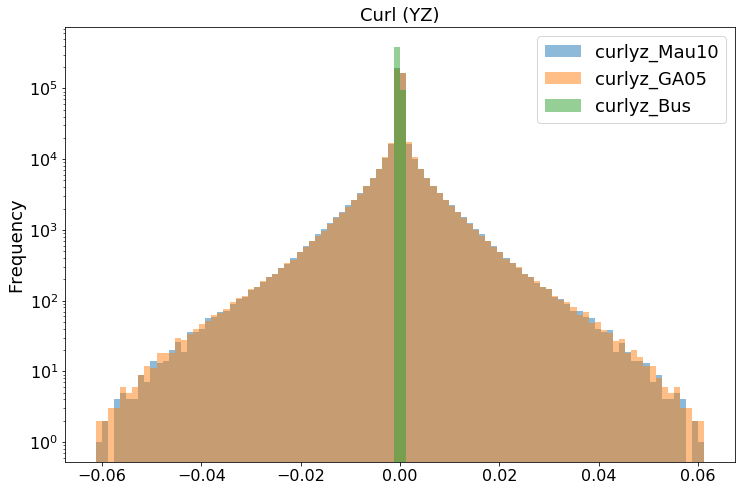

In [35]:
df_maxwell[['curlyz_Mau10','curlyz_GA05','curlyz_Bus']].plot.hist(alpha=0.5, bins=100, logy=True, title='Curl (YZ)')